<a href="https://colab.research.google.com/github/ososib/Deep-Hedging-with-cross-gamma/blob/main/Example_simulation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*By* the next code section we sequentially take a Δt step in our considered processes!

We are trying to model: \


$$ Price(t) = A(t)*B(t) ( CVA = \text{credit valuation adjustment} = pd(t) * \text{credit_exposure(t})) $$


Where:

A are credit, jump diffusion model, calibrate A from real market data.

B are interest rate. Hull white model 1F, calibrate B from real market data.

A and B are stochastic process, can be correlated or independent.



# Jump Diffusion Model

The Jump Diffusion Model is a financial model that extends the geometric Brownian motion model to account for sudden jumps in asset prices. It is described by the following stochastic differential equation:

$$ dS_t = \mu S_t dt + \sigma S_t dW_t + S_t dJ_t $$


Where:
- \( $S_t$ \) represents the asset price at time \( t \).
- \( $\mu$ \) is the drift coefficient, representing the expected continuous growth rate of the asset.
- \( $\sigma$ \) is the volatility coefficient, measuring the magnitude of random fluctuations.
- \( $W_t$ \) is a standard Wiener process, representing continuous random movements.
- \( $dJ_t$ \) represents the jump component, where jumps occur with intensity \( \lambda \) and have size distribution \( J \).

The jump diffusion model combines continuous stochastic processes (represented by the drift and diffusion terms) with discontinuous jumps (represented by the jump component), providing a more comprehensive framework for modeling asset price dynamics in financial markets.


## Applications of the Jump Diffusion Model:

- **Option pricing**: The Jump Diffusion Model is extensively utilized in option pricing, particularly for assets prone to sudden jumps in prices. By incorporating jump components, the model better captures the dynamics of asset prices, leading to more accurate option pricing.
  
- **Risk management**: In financial risk management, the Jump Diffusion Model plays a crucial role in assessing and managing risks associated with assets exhibiting discontinuous movements. By accounting for both continuous and discontinuous price changes, the model offers a more comprehensive understanding of market risk.

- **Asset valuation**: The Jump Diffusion Model is employed in valuing various financial instruments and assets, especially those susceptible to sudden shocks and discontinuities in prices. It enables analysts and investors to make informed decisions about the fair value of assets in volatile market conditions.

- **Market simulation**: Financial analysts and researchers use the Jump Diffusion Model to simulate market scenarios and study the impact of jump events on asset prices. This helps in understanding market dynamics and devising effective trading and investment strategies.

The Jump Diffusion Model's versatility and ability to capture both continuous and discontinuous price movements make it a valuable tool in various areas of finance, including option pricing, risk management, asset valuation, and market analysis.





------------------------------------------------------------------------------



# Hull-White Model

The Hull-White Model is a financial model used to describe the evolution of interest rates over time. It is a single-factor model that extends the Vasicek model by introducing mean reversion. The stochastic differential equation (SDE) for the short-term interest rate \( r_t \) under the Hull-White Model is given by:


$$ dr_t = (\theta(t) - a r_t) dt + \sigma dW_t $$


Where:
- \( $r_t$ \) represents the short-term interest rate at time \( t \).
- \( $\theta(t)$ \) is the time-dependent mean reversion level.
- \( $a$ \) is the speed of mean reversion, indicating how quickly the interest rate returns to its mean.
- \( $\sigma$ \) is the volatility of the interest rate process.
- \( $dW_t$ \) is a Wiener process representing the random shocks to the interest rate.

The Hull-White Model allows interest rates to follow a mean-reverting process, capturing the tendency for interest rates to revert towards a long-term average over time.

## Applications of the Hull-White Model:

- **Pricing of interest rate derivatives**: The model is commonly used to price various interest rate derivatives, such as bond options, interest rate swaps, and swaptions.
- **Risk management**: By providing a framework for modeling interest rate dynamics, the Hull-White Model helps financial institutions manage interest rate risk more effectively.
- **Yield curve modeling**: The model can be used to construct yield curves and analyze the term structure of interest rates, which is essential for pricing fixed-income securities.

The Hull-White Model is widely used in financial markets for interest rate modeling and derivative pricing due to its flexibility and ability to capture mean reversion dynamics.





# Sources used in this notebook (Both theory and code):


1.   Jump Diffusion: \


https://quant.stackexchange.com/questions/29606/how-to-simulate-a-jump-diffusion-process



https://www.codearmo.com/python-tutorial/merton-jump-diffusion-model-python




2.   Hull-White: \

https://en.wikipedia.org/wiki/Hull%E2%80%93White_model#Analysis_of_the_one-factor_model



https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method



For overall sequential structure:

https://github.com/fschur/Deep-Reinforcement-Learning-for-Hedging/tree/main/financial_models




In [ ]:
import numpy as np
from abc import ABC, abstractmethod


class GenericAssetPriceModel(ABC):
    @abstractmethod
    def get_current_price(self):
        pass

    @abstractmethod
    def compute_next_price(self, *action):
        pass

    @abstractmethod
    def reset(self):
        pass

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

def merton_jump_paths(S, T, r, sigma,  lam, m, v, steps, Npaths):
    size=(steps,Npaths)
    dt = T/steps
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size),
                         np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)

    return np.exp(geo+poi_rv)*S



class JDM(GenericAssetPriceModel):
    def __init__(self, s_0, r, sigma, dt, mu_J, lambda_J, sigma_J):
        self.dt = dt
        self.s_0 = s_0
        self.r = r
        self.sigma = sigma
        self.mu_J = mu_J
        self.lambda_J = lambda_J
        self.sigma_J = sigma_J
        self.current_price = s_0

    def compute_next_price(self):
        i = np.random.normal(0, np.sqrt(self.dt))
        j = np.random.poisson(self.dt*self.lambda_J)
        drift = self.r - self.lambda_J*(self.mu_J + (self.sigma_J**2)/2) - 0.5*self.sigma**2;
        jump = j*np.random.normal(self.mu_J,self.sigma_J)
        new_price = self.current_price * np.exp(drift * self.dt
                   + self.sigma * i + jump)
        self.current_price = new_price

    def reset(self):
        self.current_price = self.s_0

    def get_current_price(self):
        return self.current_price

In [3]:
import numpy as np
from abc import ABC, abstractmethod

class GenericAssetPriceModel(ABC):
    @abstractmethod
    def get_current_price(self):
        pass

    @abstractmethod
    def compute_next_price(self, *action):
        pass

    @abstractmethod
    def reset(self):
        pass

class HULL(GenericAssetPriceModel):
    def __init__(self, r_0, dt, sigma, alpha, a):
        self.current_r = r_0
        self.r_0 = r_0
        self.dt = dt
        self.sigma = sigma
        self.alpha = alpha
        self.a = a
        self.t = 0


    def compute_next_price(self, theta):
        self.current_r = self.current_r + (theta-self.alpha*self.current_r)*self.dt +  self.sigma*np.random.normal(0, np.sqrt(self.dt))

    def reset(self):
        self.current_r = self.r_0



    def get_current_price(self):
        return self.current_r

In [4]:
import numpy as np
from abc import ABC, abstractmethod

class GenericAssetPriceModel(ABC):
    @abstractmethod
    def get_current_price(self):
        pass

    @abstractmethod
    def compute_next_price(self, *action):
        pass

    @abstractmethod
    def reset(self):
        pass

class BOTH(GenericAssetPriceModel):
    def __init__(self, r_0, dt, sigma_H, alpha, s_0, r, sigma, mu_J, lambda_J, sigma_J, rho):
        self.current_r = r_0
        self.r_0 = r_0
        self.dt = dt
        self.sigma_H = sigma_H
        self.alpha = alpha
        self.s_0 = s_0
        self.r = r
        self.sigma = sigma
        self.mu_J = mu_J
        self.lambda_J = lambda_J
        self.sigma_J = sigma_J
        self.current_price = s_0
        self.rho = rho


    def compute_next_price(self, theta):
        x1 = np.random.normal(0, 1)
        x2 = np.random.normal(0, 1)
        x3 = self.rho*x1+np.sqrt(1-self.rho**2)*x2
        i = np.sqrt(self.dt)*x1
        i2 = np.sqrt(self.dt)*x3
        #i = np.random.normal(0, np.sqrt(self.dt))
        j = np.random.poisson(self.dt*self.lambda_J)

        drift = self.r - self.lambda_J*(self.mu_J + (self.sigma_J**2)/2) - 0.5*self.sigma**2;
        jump = j*np.random.normal(self.mu_J,self.sigma_J)
        new_price = self.current_price * np.exp(drift * self.dt
                   + self.sigma * i + jump)
        self.current_price = new_price

        self.current_r = self.current_r + (theta-self.alpha*self.current_r)*self.dt+self.sigma_H*i2#np.random.normal(0, np.sqrt(self.dt))



    def reset(self):
        self.current_r = self.r_0
        self.current_price = self.s_0

    def get_current_price(self):
        return self.current_r, self.current_price

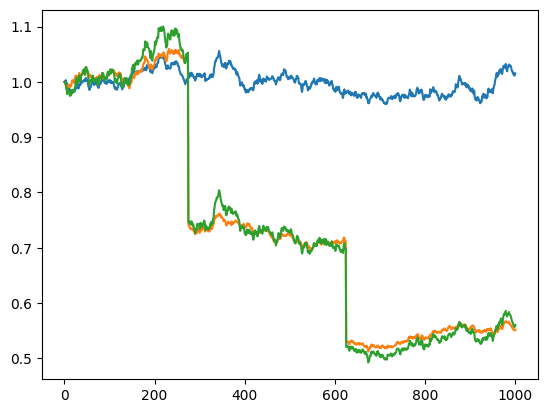

In [17]:
import matplotlib.pyplot as plt

#from scipy.stats import pearsonr
#from scipy.stats import spearmanr



dt = 1/1000 # time step
sigma_H = 0.1 # (annaul?) standard deviation , for weiner process
r_H = 1  # current rate, Hull

alpha = 0.1

mu_J = 0 # meean of jump size
s_0 = 1 # current price
sigma = 0.1 # (annaul?) standard deviation , for weiner process
r = 0.1 # risk free rate
lambda_J = 1 # intensity of jump i.e. number of jumps per annum
sigma_J = 0.5 # standard deviation of jump


rho = 0.5

apm = BOTH(r_0=r_H, dt = dt, sigma_H = sigma_H, alpha = alpha, s_0=s_0, r=r, sigma=sigma, mu_J=mu_J, lambda_J=lambda_J, sigma_J=sigma_J, rho=rho)
prices = apm.get_current_price()
price2=[prices[0]]
price1=[prices[1]]
for i in range(0,1000):
  apm.compute_next_price(theta=0.03+0.001*i*((-1)**i))
  prices = apm.get_current_price()
  price2.append(prices[0])
  price1.append(prices[1])

plt.plot(price2)


plt.plot(price1)

price = [a*b for a,b in zip(price1,price2)]
plt.plot(price)


#diffprice1 = [x - price1[i - 1] for i, x in enumerate(price1)][1:]
#diffprice2 = [x - price2[i - 1] for i, x in enumerate(price2)][1:]

#corr, _ = pearsonr(diffprice1, diffprice2)
#corr, _ = spearmanr(price1, price2)

#print(corr)
#print(rho*sigma*np.sqrt(np.exp(sigma**2)-1)) #correlation = rho*sigma*np.sqrt(np.exp(sigma**2)-1     doesn't seem to be true. HUH?

